<a href="https://colab.research.google.com/github/nupoorsagar/FruitClassifier-using-MobileNetV2/blob/main/optimised.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import zipfile
import os

zip_path = "/content/train_aug_images.zip"  # Update if needed
extract_path = "/content/fruits_aug_dataset"

# Unzipping
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

# Check extracted files
os.listdir(extract_path)

['mango fruit',
 'strawberry fruit',
 'cherry fruit',
 'apple fruit',
 'chickoo fruit',
 'kiwi fruit',
 'banana fruit',
 'grapes fruit',
 'orange fruit']

In [ ]:
import cv2
import numpy as np
from PIL import Image

def preprocess_image_for_model(img_path, target_size=(96, 96)):
    # Load image using OpenCV
    img = cv2.imread(img_path)

    # Remove background with thresholding (basic technique)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    _, mask = cv2.threshold(gray, 245, 255, cv2.THRESH_BINARY_INV)

    # Create white background
    white_bg = np.ones_like(img, dtype=np.uint8) * 255
    img_no_bg = cv2.bitwise_and(img, img, mask=mask)
    inv_mask = cv2.bitwise_not(mask)
    white_bg = cv2.bitwise_and(white_bg, white_bg, mask=inv_mask)
    final_img = cv2.add(img_no_bg, white_bg)

    # Apply CLAHE to each channel
    lab = cv2.cvtColor(final_img, cv2.COLOR_BGR2LAB)
    l, a, b = cv2.split(lab)
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    cl = clahe.apply(l)
    limg = cv2.merge((cl, a, b))
    enhanced = cv2.cvtColor(limg, cv2.COLOR_LAB2BGR)

    # Resize and normalize
    enhanced = cv2.resize(enhanced, target_size)
    enhanced = enhanced.astype('float32') / 255.0
    return np.expand_dims(enhanced, axis=0)  # Shape: (1, h, w, 3)

In [ ]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, GlobalAveragePooling2D, Dropout, Dense
from tensorflow.keras.optimizers import Adam

def build_model(num_classes):
    base = MobileNetV2(input_shape=(96, 96, 3), include_top=False, weights='imagenet')
    base.trainable = False  # Freeze feature extractor

    inputs = Input(shape=(96, 96, 3))
    x = base(inputs, training=False)
    x = GlobalAveragePooling2D()(x)
    x = Dropout(0.3)(x)
    outputs = Dense(num_classes, activation='softmax')(x)

    model = Model(inputs, outputs)
    model.compile(optimizer=Adam(1e-4), loss='categorical_crossentropy', metrics=['accuracy'])
    return model

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_gen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    zoom_range=0.2,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest'
)

train_data = train_gen.flow_from_directory(
    '/content/fruits_aug_dataset',  # ✅ Use only the augmented folder
    target_size=(96, 96),
    batch_size=32,
    class_mode='categorical'
)

num_classes = len(train_data.class_indices)
model = build_model(num_classes)

history = model.fit(train_data, epochs=20)

# Save the trained model
model.save("mobilenetv2_fruit_classifier.h5")


Found 2876 images belonging to 9 classes.
Epoch 1/20
90/90 ━━━━━━━━━━━━━━━━━━━━ 84s 870ms/step - accuracy: 0.2158 - loss: 2.4624
Epoch 2/20
90/90 ━━━━━━━━━━━━━━━━━━━━ 77s 859ms/step - accuracy: 0.4110 - loss: 1.7724
Epoch 3/20
90/90 ━━━━━━━━━━━━━━━━━━━━ 74s 820ms/step - accuracy: 0.5353 - loss: 1.3784
Epoch 4/20
90/90 ━━━━━━━━━━━━━━━━━━━━ 74s 816ms/step - accuracy: 0.6393 - loss: 1.0961
Epoch 5/20
90/90 ━━━━━━━━━━━━━━━━━━━━ 76s 834ms/step - accuracy: 0.7068 - loss: 0.9136
Epoch 6/20
90/90 ━━━━━━━━━━━━━━━━━━━━ 76s 839ms/step - accuracy: 0.7381 - loss: 0.7898
Epoch 7/20
90/90 ━━━━━━━━━━━━━━━━━━━━ 76s 846ms/step - accuracy: 0.7738 - loss: 0.6943
Epoch 8/20
90/90 ━━━━━━━━━━━━━━━━━━━━ 75s 836ms/step - accuracy: 0.7919 - loss: 0.6500
Epoch 9/20
90/90 ━━━━━━━━━━━━━━━━━━━━ 78s 868ms/step - accuracy: 0.8128 - loss: 0.5853
Epoch 10/20
90/90 ━━━━━━━━━━━━━━━━━━━━ 74s 820ms/step - accuracy: 0.8148 - loss: 0.5551
Epoch 11/20
90/90 ━━━━━━━━━━━━━━━━━━━━ 81s 899ms/step - accuracy: 0.8362 - loss: 0.5041

Found 45 images belonging to 9 classes.


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 1s/step
Classification Report:

              precision    recall  f1-score   support

       apple       1.00      0.80      0.89         5
      banana       1.00      0.60      0.75         5
      cherry       1.00      1.00      1.00         5
     chickoo       0.62      1.00      0.77         5
      grapes       1.00      0.80      0.89         5
        kiwi       0.83      1.00      0.91         5
       mango       0.62      1.00      0.77         5
      orange       1.00      0.60      0.75         5
  strawberry       1.00      0.80      0.89         5

    accuracy                           0.84        45
   macro avg       0.90      0.84      0.85        45
weighted avg       0.90      0.84      0.85        45



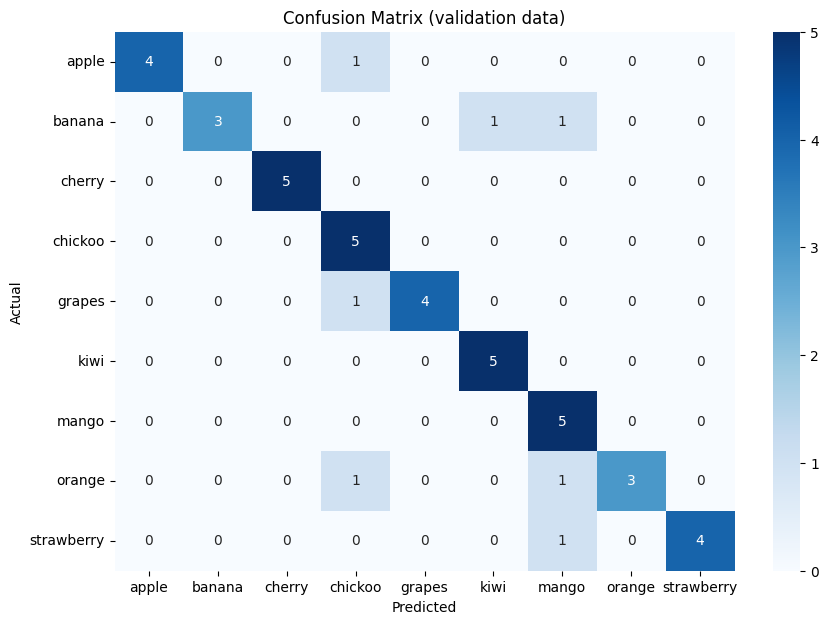

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.models import load_model

model = load_model("/content/mobilenetv2_fruit_classifier.h5")

from tensorflow.keras.preprocessing.image import ImageDataGenerator
datagen = ImageDataGenerator(rescale=1.0/255)
train_data = datagen.flow_from_directory(
    '/content/validation_images',
    target_size=(96, 96),
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)
pred_probs = model.predict(train_data)
y_pred = np.argmax(pred_probs, axis=1)
y_true = train_data.classes
class_labels = list(train_data.class_indices.keys())
print("Classification Report:\n")
print(classification_report(y_true, y_pred, target_names=class_labels))
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=class_labels, yticklabels=class_labels, cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix (validation data)')
plt.show()

In [ ]:
from tensorflow.keras.models import load_model

# Load trained model
model = load_model("mobilenetv2_fruit_classifier.h5")

# Load and preprocess new image
img_path = "/content/Screenshot 2025-04-05 at 6.52.09 PM.png"  # Replace
processed_img = preprocess_image_for_model(img_path, target_size=(96, 96))

# Predict
pred = model.predict(processed_img)
class_index = np.argmax(pred)
confidence = np.max(pred)

# Map index to class
class_labels = {v: k for k, v in train_data.class_indices.items()}

print(f"Predicted Class: {class_labels[class_index]} with confidence {confidence:.2f}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
Predicted Class: banana with confidence 0.38


In [ ]:
import zipfile
import os

zip_path = "/content/validation_5_each.zip"  # Update if needed
extract_path = "/content/validation_images"

# Unzipping
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

# Check extracted files
os.listdir(extract_path)

['apple',
 'cherry',
 'banana',
 'grapes',
 'mango',
 'chickoo',
 'strawberry',
 'kiwi',
 'orange']

In [ ]:
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Load saved model
model = load_model('/content/mobilenetv2_fruit_classifier.h5')

# Define validation data directory
validation_dir = "/content/validation_images"

# Preprocess images (resize and normalize)
val_datagen = ImageDataGenerator(rescale=1./255)

val_generator = val_datagen.flow_from_directory(
    validation_dir,
    target_size=(96, 96),  # <- change this to 96x96
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)
# Evaluate model on validation data
loss, accuracy = model.evaluate(val_generator)
print(f'Validation Accuracy: {accuracy * 100:.2f}%')

Found 45 images belonging to 9 classes.
2/2 ━━━━━━━━━━━━━━━━━━━━ 4s 137ms/step - accuracy: 0.8546 - loss: 0.6213
Validation Accuracy: 84.44%
